In [1]:
!pip install little_mallet_wrapper

# IMPORTING LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import little_mallet_wrapper as lmw
import glob
import os
from gensim.models import CoherenceModel
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import spacy
import gensim
from gensim import corpora
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import matplotlib.patches as mpatches
#Lemmatization library
!python -m spacy download en_core_web_md 
import en_core_web_sm
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer



# libraries for visualization
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pyLDAvis
warnings.filterwarnings('ignore')

In [4]:
#Enable viz
pyLDAvis.enable_notebook()

In [19]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# IMPORTING DATA

In [5]:
#Mounting colab to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#Defining directory for importing files
#sri root = "/content/drive/MyDrive/USML_Final_Project/topic-modeling-datasets-master/data/raw/20news-bydate/20news-bydate-train"
root='/content/drive/MyDrive/uml_project/20news-bydate-train/'

In [8]:
#Retrieving documents from the following newsgroup folders
f=['sci.crypt',
 'rec.sport.baseball',
 'sci.med',
 'rec.motorcycles',
 'talk.religion.misc',
 'comp.sys.ibm.pc.hardware',
 'sci.space',
 'rec.motorcycles',
 'comp.graphics',
 'talk.politics.guns']

In [11]:
#Function for reading files
def read_files(file_path):
   with open(file_path, 'r') as file:
      print(file.read())

In [14]:
#Checking the directory folder
os.chdir(root)
os.listdir()

['comp.windows.x',
 'comp.os.ms-windows.misc',
 'rec.sport.baseball',
 'rec.motorcycles',
 'misc.forsale',
 'comp.graphics',
 'rec.autos',
 'comp.sys.mac.hardware',
 'alt.atheism',
 'comp.sys.ibm.pc.hardware',
 'talk.religion.misc',
 'sci.crypt',
 'rec.sport.hockey',
 'soc.religion.christian',
 'talk.politics.mideast',
 'sci.electronics',
 'talk.politics.guns',
 'sci.space',
 'sci.med',
 'talk.politics.misc']

In [15]:
#Importing files from google drive
file_content = []
for direc in f:
  for file in os.listdir(root+"/"+direc):
      file_path =f"{root}/{direc}/{file}"
      file_size = os.path.getsize(file_path)
      fd = open(file_path,encoding="ISO-8859-1")
      content = fd.read(file_size)
      file_content.append(content)

In [16]:
df = pd.DataFrame(file_content,columns=["body"])
df.head()

,body
0,From: mvanheyn@cs.indiana.edu (Marc VanHeyning...
1,From: Marc VanHeyningen <mvanheyn@cs.indiana.e...
2,From: WHMurray@DOCKMASTER.NCSC.MIL\nSubject: L...
3,From: Jim-Miller@suite.com\nSubject: Certifyin...
4,From: gtoal@gtoal.com (Graham Toal)\nSubject: ...


# PREPROESSING

In [17]:
#Function for preprocessing data
def clean_message(message):
    '''
    Input:
        message: a string containing a message.
    Output:
        messages_cleaned: a list of words containing the processed message. 

    '''
    #Remove emails
    messages_cleaned = re.sub(r'\S+@\S+','',message)

    #Remove Punctuation
    messages_cleaned = re.sub(r'[^\w\s]', '', messages_cleaned)
    
    #Remove Links
    messages_cleaned = re.sub(r'https?://\S+', '', messages_cleaned)

    #Removing alphanumeric
    messages_cleaned =re.sub( r'([a-zA-Z]*\d+[a-zA-Z]+|[a-zA-Z]+\d+[a-zA-Z]*)','',messages_cleaned) 
  
    #Removing number with text:
    messages_cleaned = re.sub(r'\d+', '', messages_cleaned)

    #Removing stand alone numbers:
    messages_cleaned = re.sub(r'[0-9]', '', messages_cleaned)


    #Lower Case
    messages_cleaned = messages_cleaned.lower()
    
    #Tokenize
    messages_cleaned = word_tokenize(messages_cleaned)
    
    #Remove Stopwords
    stop_words_list = stopwords.words('english')
    for token in messages_cleaned:
        if token in stop_words_list:
            messages_cleaned.remove(token)
    cl=""
    for i in messages_cleaned:
      cl=cl+" "+i

    #Perform Stemming
#     temp = messages_cleaned.copy()
#     messages_cleaned.clear()
#     for token in temp:
#         messages_cleaned.append(PorterStemmer().stem(token))
    
    return cl

In [20]:
#Preprocessing text
df['messages_string'] = df['body'].apply(lambda row: clean_message(row))

In [22]:
#Let's have a look at our preprocessed text (messages_string)
df.head()

,body,messages_string
0,From: mvanheyn@cs.indiana.edu (Marc VanHeyning...,marc vanheyningen subject ripem frequently as...
1,From: Marc VanHeyningen <mvanheyn@cs.indiana.e...,marc vanheyningen subject ripem frequently as...
2,From: WHMurray@DOCKMASTER.NCSC.MIL\nSubject: L...,subject licensing organization yale cs mailne...
3,From: Jim-Miller@suite.com\nSubject: Certifyin...,subject certifying authority question answere...
4,From: gtoal@gtoal.com (Graham Toal)\nSubject: ...,graham toal subject hard drive security fbi t...


In [25]:
#Function to perform lemmatization
nlp = en_core_web_sm.load(disable=['parser', 'ner'])
def lemmatization(texts,allowed_postags=[ 'NOUN', 'ADJ', 'ADV']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [26]:
#Performing Lemmatization
text_list=df['messages_string'].tolist()
tokenized_reviews = lemmatization(text_list)

In [27]:
#Appending the content to dataframe
df['clean_list']=tokenized_reviews

In [28]:
#Appending the content as a string to dataframe
df['clean_string']=df['clean_list'].apply(lambda row: " ".join(row))

In [29]:
#Let's have a look at our dataframe
df.head()

,body,messages_string,clean_list,clean_string
0,From: mvanheyn@cs.indiana.edu (Marc VanHeyning...,marc vanheyningen subject ripem frequently as...,"[frequently, question, articleid, science, lin...",frequently question articleid science line tit...
1,From: Marc VanHeyningen <mvanheyn@cs.indiana.e...,marc vanheyningen subject ripem frequently as...,"[frequently, question, faq, originator, supers...",frequently question faq originator supersede c...
2,From: WHMurray@DOCKMASTER.NCSC.MIL\nSubject: L...,subject licensing organization yale cs mailne...,"[subject, line, actually, bill, speculation, b...",subject line actually bill speculation backdoo...
3,From: Jim-Miller@suite.com\nSubject: Certifyin...,subject certifying authority question answere...,"[subject, question, software, line, several, d...",subject question software line several documen...
4,From: gtoal@gtoal.com (Graham Toal)\nSubject: ...,graham toal subject hard drive security fbi t...,"[hard, drive, security, line, separate, locati...",hard drive security line separate location cre...


# Preparing Document-Term Matrix for LDA

In [30]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dictionary = corpora.Dictionary(tokenized_reviews)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokenized_reviews]

# LATENT DIRICHLET ALLOCATION

In [33]:
#This function will perform LDA for various values of n (number of topics) return models as well as their coherence scores
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values_lda = []
    model_list_lda = []
    for num_topics in range(start, limit, step):
        # LDA training
        model_lda = lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)
      
        model_list_lda.append(model_lda)
        coherencemodel_lda = CoherenceModel(model=model_lda, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_lda.append(coherencemodel_lda.get_coherence())

    return model_list_lda, coherence_values_lda


In [35]:
#Function for visualizing coherence scores
def coherence_viz(coherence_values,title, limit, start, step):
    """
    Performance visualization

    Parameters:
    ----------
    coherence_values : List of coherence values
    title : The title of the model
    limit : Upper topic limit 
    start : Minimum number of topics
    step  : Step
    
    Returns:
    -------
  
    """
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.title(title)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [31]:
#Storing the column as a list
text = df['clean_list'].tolist()

In [34]:
model_list_lda, coherence_values_lda=model_list_lda, coherence_values_lda= compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=text, start=6, limit=16, step=2)

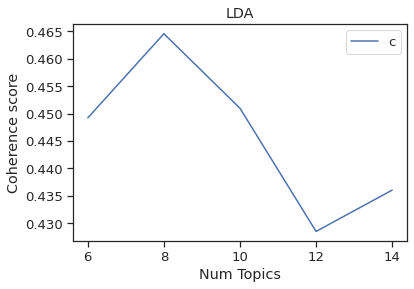

In [36]:
#Plotting coherence plot to get optimal value of n
coherence_viz(coherence_values_lda,'LDA', 16,6,2)

In [ ]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=100,iterations=100, random_state=100, chunksize=1000, alpha='auto', per_word_topics=True, update_every=1)

In [44]:
#Printing topics
model_list_lda[1].print_topics()

[(0,
  '0.029*"line" + 0.018*"article" + 0.013*"time" + 0.012*"good" + 0.011*"well" + 0.011*"thing" + 0.011*"subject" + 0.009*"even" + 0.009*"people" + 0.009*"way"'),
 (1,
  '0.039*"car" + 0.018*"launch" + 0.015*"satellite" + 0.013*"orbit" + 0.012*"rocket" + 0.011*"bullet" + 0.010*"wife" + 0.009*"shuttle" + 0.009*"medical" + 0.008*"attorney"'),
 (2,
  '0.057*"file" + 0.019*"information" + 0.015*"email" + 0.013*"format" + 0.013*"program" + 0.013*"available" + 0.011*"address" + 0.010*"list" + 0.009*"site" + 0.008*"also"'),
 (3,
  '0.056*"gun" + 0.022*"people" + 0.021*"right" + 0.021*"weapon" + 0.019*"law" + 0.017*"firearm" + 0.012*"government" + 0.012*"crime" + 0.011*"state" + 0.010*"child"'),
 (4,
  '0.028*"criminal" + 0.014*"safety" + 0.012*"police" + 0.012*"cop" + 0.012*"government" + 0.012*"officer" + 0.010*"agent" + 0.010*"dangerous" + 0.009*"trial" + 0.008*"glock"'),
 (5,
  '0.030*"image" + 0.020*"system" + 0.016*"graphic" + 0.013*"card" + 0.012*"space" + 0.012*"software" + 0.011*"

In [45]:
#Model Evaluation
print('\nPerplexity: ', model_list_lda[1].log_perplexity(doc_term_matrix,total_docs=5672))
print("Coherence score: ",coherence_values_lda[1])


Perplexity:  -8.434566773200912
Coherence score:  0.4645899216285666


In [46]:
#Visualizing different topics and their terms
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model_list_lda[1], doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.302873  0.033298       1        1  38.998231
5      0.139619 -0.151842       2        1  13.735647
3      0.042310  0.342828       3        1  12.706696
2      0.111864 -0.164766       4        1   9.305312
7     -0.140766  0.011362       5        1   7.954209
4     -0.113685  0.103821       6        1   7.934210
6     -0.141602 -0.111907       7        1   5.423233
1     -0.200612 -0.062795       8        1   3.942461, topic_info=             Term         Freq        Total Category  logprob  loglift
1063          gun  2973.000000  2973.000000  Default  30.0000  30.0000
138          file  2615.000000  2615.000000  Default  29.0000  29.0000
200          line  4753.000000  4753.000000  Default  28.0000  28.0000
1380        image  1705.000000  1705.000000  Default  27.0000  27.0000
269        people  2649.000000  2649.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
3038        earth    98.154983   249.854265   Topic8  -5.1286   2.2990
16151    launcher    65.810281    92.494921   Topic8  -5.5283   2.8930
1543       policy    62.096705   121.052239   Topic8  -5.5864   2.5658
996    commercial    62.464538   218.757109   Topic8  -5.5805   1.9800
381    technology    62.947348   304.715480   Topic8  -5.5728   1.6563

[387 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4         3  0.996415    action
5         1  0.999072  actually
1130      4  0.996900   address
9         6  0.993819    agency
10        6  0.996032     agent
...     ...       ...       ...
1785      2  0.997593    window
2425      3  0.994450     woman
410       1  0.999202     world
654       1  0.980589      year
654       3  0.018857      year

[486 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 4, 3, 8, 5, 7, 2])

# NON NEGATIVE MATRIX FACTORIZATION

In [47]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(analyzer='word',max_df=0.95, min_df=10)
tfidf = tfidf_vectorizer.fit_transform(df['clean_string'])
tfidf_tokens = tfidf_vectorizer.get_feature_names()
df_tfidfvect = pd.DataFrame(data = tfidf.toarray(),index = [i for i in range(0,len(df))],columns = tfidf_tokens)

Extracting tf-idf features for NMF...


In [49]:
#Let's have a look at our matrix
df_tfidfvect.head()

,aaa,ab,ability,able,abortion,about,above,abroad,absence,absent,...,year,yeast,yellow,yesterday,yet,yield,young,youth,zipgun,zone
0,0.0,0.0,0.0,0.024677,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.025780,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.032682,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.017072,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [50]:
#Function to print top words from topics
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


In [51]:
#Fitting NMF
#Using KL Divergence as the Cost function 
#Trying for different values of no. of topics
n_components_list=[6,8,10,12,14]
w=[]
h=[]
for i in n_components_list:
  model= NMF(n_components=i,random_state=1,beta_loss="kullback-leibler",solver="mu",alpha=0.1,l1_ratio=0.5)
  w.append(model.fit(df_tfidfvect))
  h.append(model.components_)
  print("Topics found via NMF for topics= ",i)
  print_top_words(w[-1], tfidf_tokens, 10)



Topics found via NMF for topics=  6

Topic #0:
article people line time good also thing many way subject

Topic #1:
key chip government clipper encryption phone public system law secret

Topic #2:
thank line file email program graphic subject image software version

Topic #3:
bike motorcycle dog helmet rider article ride line front subject

Topic #4:
game team player year baseball good last season run line

Topic #5:
gun drive card driver bus disk scsi controller hard problem

Topics found via NMF for topics=  8

Topic #0:
people time article line good right well other way thing

Topic #1:
key chip clipper encryption government phone system public secret security

Topic #2:
thank line file email program subject graphic image software version

Topic #3:
bike motorcycle dog helmet rider article ride line front car

Topic #4:
game team player year baseball last good season run fan

Topic #5:
drive gun card bus disk scsi problem system controller ide

Topic #6:
space food orbit science yea

In [52]:
#Generating embedding for NMF
nmf_embedding = w[-1].transform(df_tfidfvect)
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

In [53]:
#Function for creating a dataframe of terms and topics
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = tfidf_tokens
    
    word_dict = {};
    for i in range(0,14):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-10 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict)

In [54]:
get_nmf_topics(w[-1], 14)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14
0,people,key,thank,bike,game,drive,doctor,card,gun,bit,space,jewish,government,helmet
1,time,chip,line,motorcycle,team,bus,effect,bank,line,image,orbit,child,right,dog
2,thing,clipper,email,rider,player,disk,patient,video,law,color,station,food,technology,ticket
3,good,encryption,program,article,year,scsi,disease,monitor,weapon,file,lunar,god,article,article
4,other,phone,file,ride,baseball,system,science,soon,firearm,problem,launch,article,militia,moa
5,line,system,version,line,last,controller,treatment,driver,subject,time,moon,christian,cost,face
6,also,government,graphic,front,season,ide,pain,line,criminal,well,earth,objective,company,line
7,well,secret,software,tire,run,hard,study,too,crime,way,mission,gas,why,car
8,way,public,subject,advice,fan,problem,problem,mode,public,screen,satellite,religion,software,road
9,article,security,help,mile,good,port,medical,science,police,just,spacecraft,morality,federal,jacket


In [55]:
#Topic names for TSNE visualization
topics = ['0','1','2','3','4','5','6','7','8','9','10','12','13']

In [56]:

tsne = TSNE(random_state=3211)
tsne_embedding = tsne.fit_transform(nmf_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = nmf_embedding.argmax(axis=1)

In [57]:
tsne_embedding.head()

,x,y,hue
0,-6.083026,87.183159,1
1,-6.116098,87.205673,1
2,-13.995474,67.079384,1
3,-18.483963,-21.899321,2
4,-2.393610,40.677471,12


In [ ]:
#Ignore this section
# legend_list = []

# data = tsne_embedding
# scatter = plt.scatter(data=data,x='x',y='y',s=14,c=data['hue'],cmap="inferno")
# plt.axis('off')
# plt.show()

# colors = []
# for i in range(len(topics)):
#     idx = np.where(data['hue']==i)[0][0]
#     color = scatter.get_facecolors()[idx]
#     colors.append(color)
#     legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))

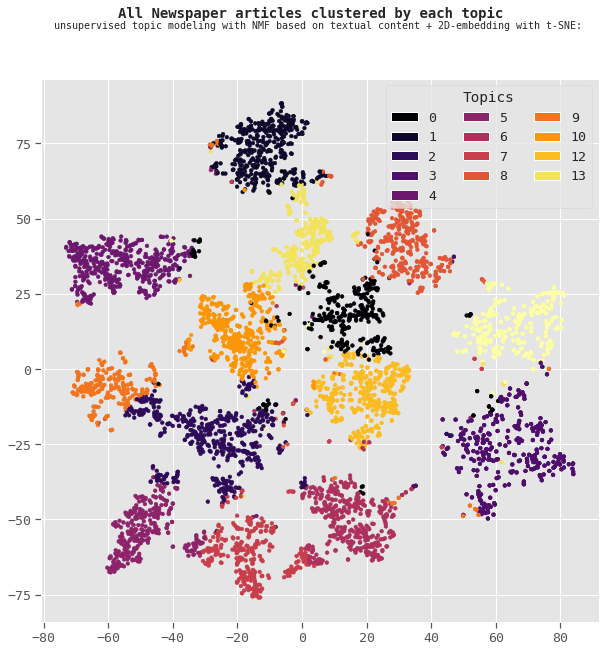

In [62]:
#Visualizing topics using TSNE
matplotlib.rc('font',family='monospace')
plt.style.use('ggplot')


fig= plt.figure(figsize=(10,10), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = .1, wspace=0)


data = tsne_embedding
scatter=plt.scatter(data=data,x='x',y='y',s=14,c=data['hue'],cmap="inferno")
#axs.set_title('published until {}'.format(year),**{'fontsize':'10'})
    #xs[idx].axis('off')



plt.suptitle("All Newspaper articles clustered by each topic",**{'fontsize':'14','weight':'bold'})
plt.figtext(.51,0.95,'unsupervised topic modeling with NMF based on textual content + 2D-embedding with t-SNE:', **{'fontsize':'10','weight':'light'}, ha='center')

plt.legend(legend_list,topics,ncol=3,title="Topics")
#fig.legend(topics,ncol=3)
#plt.subplots_adjust(top=0.85)

plt.show()
loc=(0.1,0.89)

# KMEANS

In [63]:
#The dimension are over 3000. Reducing dimensions using svd
print("reducing tf-idf to 500 dim")
tfs_reduced = TruncatedSVD(n_components=500, random_state=0).fit_transform(df_tfidfvect)
print("done")

reducing tf-idf to 500 dim
done


N_clusters =  6
N_clusters =  7
N_clusters =  8
N_clusters =  9
N_clusters =  10
N_clusters =  11
N_clusters =  12
N_clusters =  13
N_clusters =  14
N_clusters =  15


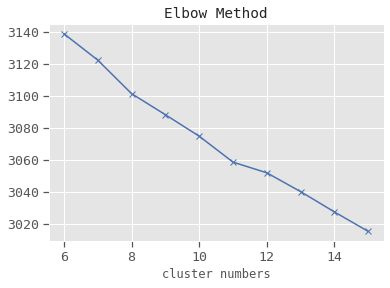

In [64]:
#Plotting SSE vs Number of clusters to get optimal number of clusters
K = range(6,16)
SSE = []
for k in K:
  print("N_clusters = ",k)
  model = KMeans(n_clusters=k, init = 'random', max_iter =50, n_init=100)
  model_fit=model.fit(tfs_reduced)
  kmeans=model_fit.predict(tfs_reduced)
  SSE.append(model.inertia_)

plt.plot(K,SSE,'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [65]:
#Performing kmeans clustering
k = KMeans(n_clusters=9, init = 'k-means++', max_iter =50, n_init=100)

k.fit(tfs_reduced)

k.predict(tfs_reduced)

array([4, 4, 1, ..., 0, 0, 1], dtype=int32)

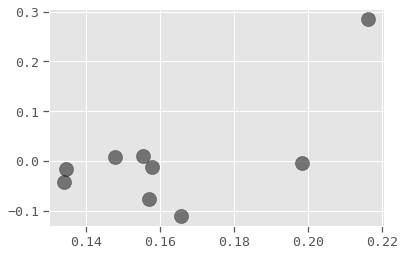

In [66]:
#Plotting cluster centres
centers = k.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [67]:
#Storing cluster assignments
clusters = k.labels_.tolist()

In [87]:
#Creating tsne embedding for visualization
tsne_embedding = pd.DataFrame(tfs_embedded,columns=['x','y'])
tsne_embedding['hue'] = clusters

In [69]:
#Let's have a look at our 2D embedding
tsne_embedding.head()

,x,y,hue
0,-6.083026,87.183159,1
1,-6.116098,87.205673,1
2,-13.995474,67.079384,1
3,-18.483963,-21.899321,2
4,-2.393610,40.677471,12


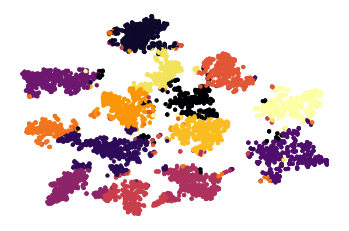

In [70]:
legend_list = []
topics = ['1','2','3','4','5','6','7','8','9']
data = tsne_embedding
scatter = plt.scatter(data=data,x='x',y='y',s=14,c=data['hue'],cmap="inferno")
plt.axis('off')
plt.show()

colors = []
for i in range(len(topics)):
    idx = np.where(data['hue']==i)[0][0]
    color = scatter.get_facecolors()[idx]
    colors.append(color)
    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))

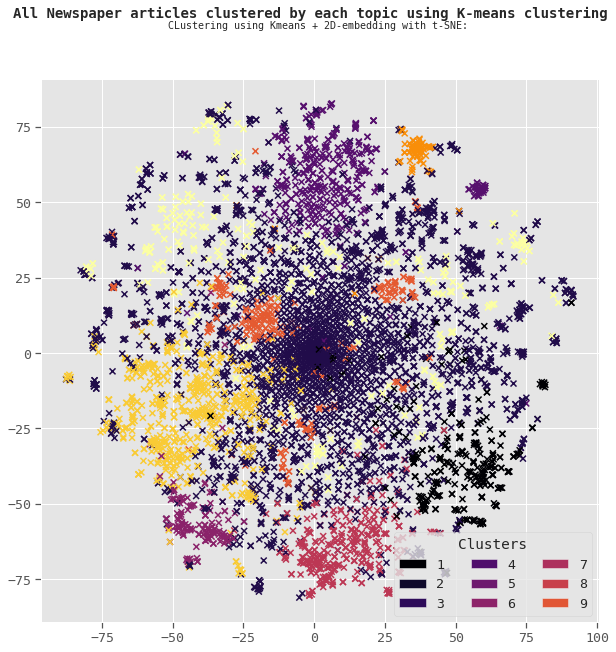

In [71]:
#Visualizing our data 
tfs_embedded = TSNE(n_components=2, perplexity=40).fit_transform(tfs_reduced)
fig = plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.scatter(tfs_embedded[:, 0], tfs_embedded[:, 1], marker = "x", c = k.labels_,cmap="inferno")



plt.suptitle("All Newspaper articles clustered by each topic using K-means clustering",**{'fontsize':'14','weight':'bold'})
plt.figtext(.51,0.95,'CLustering using Kmeans + 2D-embedding with t-SNE:', **{'fontsize':'10','weight':'light'}, ha='center')

plt.legend(legend_list,topics,ncol=3,title="Clusters")
#fig.legend(topics,ncol=3)
#plt.subplots_adjust(top=0.85)

plt.show()
loc=(0.1,0.89)

plt.show()

In [73]:
#Evaluation
from sklearn.metrics import davies_bouldin_score as dbs
from sklearn.metrics import silhouette_score as ss
print("DB index of K-Means clustering with n=9: ",dbs(tfs_reduced, clusters))
print("Silhouette Score of K-Means clustering with n=9 ", ss(tfs_reduced, clusters, metric='euclidean'))

DB index of K-Means clustering with n=9:  5.217974908984303
Silhouette Score of K-Means clustering with n=9  0.0181100313907707


# Latent Semantic Analysis